In [1]:
include("../../juliasrc/calculate_potentials.jl");

 Activating environment at `/run/media/zhanibek/BE7C43F57C43A74D/PROJECTS/local-bpm-e34/Project.toml`
┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1260
┌ Info: Precompiling ProgressMeter [92933f4c-e287-5a05-a399-4b506db050ca]
└ @ Base loading.jl:1260
┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1260
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260


In [2]:
function mse(a::MinimizationTarget, b::MinimizationTarget)
    currents =  mean(@. (a.currents - b.currents)^2)
    return exp(1e5*(a.std_x - b.std_x)^2) - 1 + exp(1e5*(a.std_y - b.std_y)^2) -1 + currents
end


mse (generic function with 2 methods)

In [3]:
using Images
using ImageQualityIndexes

┌ Info: Precompiling Images [916415d5-f1e6-5110-898d-aaa5f9f070e0]
└ @ Base loading.jl:1260


In [4]:
function get_ssim_error(x,y)
    a = fit(Histogram, (x[:,1], x[:,2]), (range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1), range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)))
    b = fit(Histogram, (y[:,1], y[:,2]), (range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1), range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)))
    # return mean((a.weights  - b.weights ).^2)
    assess_ssim(a.weights./maximum(a.weights), b.weights./maximum(b.weights))
end

get_ssim_error (generic function with 1 method)

In [5]:
function get_pixel_error(x, y)
    a = fit(Histogram, (x[:,1], x[:,2]), (range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1), range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)))
    b = fit(Histogram, (y[:,1], y[:,2]), (range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1), range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)))
    return mean((a.weights  - b.weights ).^2)
end

get_pixel_error (generic function with 1 method)

In [6]:
std_noise_levels = [0, 10, 20, 30];

In [7]:
probe_noise_levels = ["00", "02", "04", "06", "08", "1"];

In [8]:
using CSV, DataFrames, Glob

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1260


In [9]:
test_samples = [convert(Matrix,CSV.read(filename, header=false)) for filename in glob("data/testsamples/*.csv")];

In [10]:
probe_noised = [[convert(Matrix,CSV.read(filename, header=false)) for filename in glob("data/probe_noise/$i/*.csv")] for i in probe_noise_levels];

In [11]:
std_noised = [[convert(Matrix,CSV.read(filename, header=false)) for filename in glob("data/std_noise/$i/*.csv")] for i in std_noise_levels];

In [12]:
std_noised_errors = [[get_ssim_error(std_noised[j][i], test_samples[i]) for i in eachindex(test_samples)] for j in eachindex(std_noised)];

In [13]:
probe_noised_errors = [[get_ssim_error(probe_noised[j][i], test_samples[i]) for i in eachindex(test_samples)] for j in eachindex(probe_noised)];

# Noise on the <x^2> and <y^2>

In [14]:
using LaTeXStrings

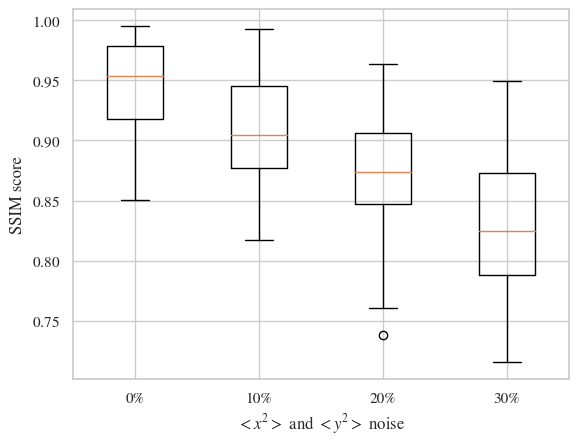

PyObject Text(26.015625, 0.5, 'SSIM score')

In [15]:
boxplot(std_noised_errors)
xticks([1, 2, 3, 4], ["0%", "10%", "20%", "30%"])
xlabel(L"$<x^2>$ and $<y^2>$ noise")
ylabel("SSIM score")
# savefig("paper_plots/ssim_vs_noise2.png", dpi=500)

In [16]:
plotting_indices = [5, 16, 50, 44, 37, 30]# 40:50 #  [4, 26, 24, 50, 20]   # 20 extremely distorted  # 24 elongated # 1, 4, 30, 37, 44 less distorted


# paper [5, 16, 50, 44 37]

6-element Array{Int64,1}:
  5
 16
 50
 44
 37
 30

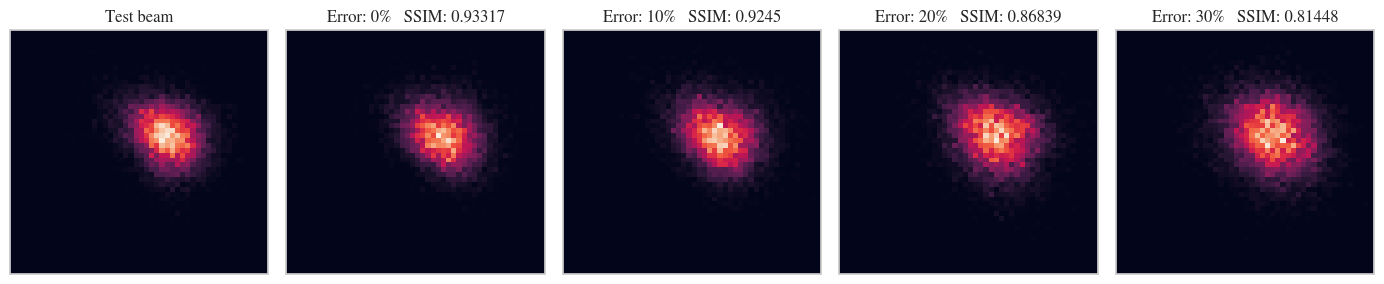

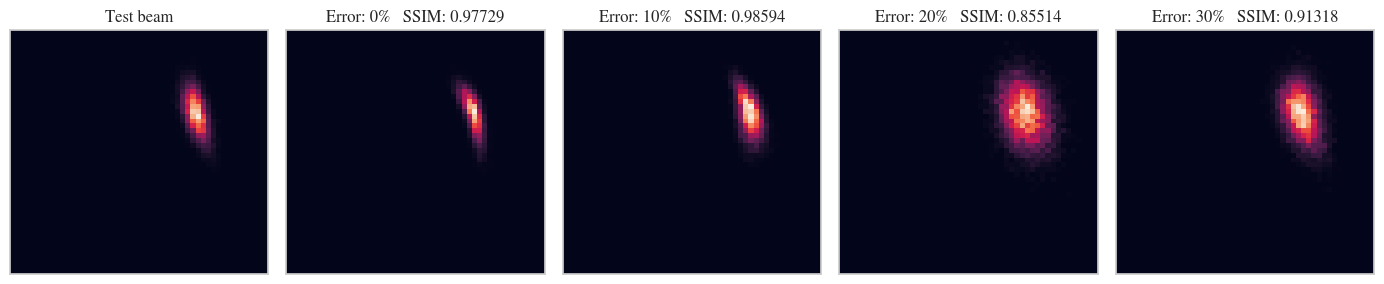

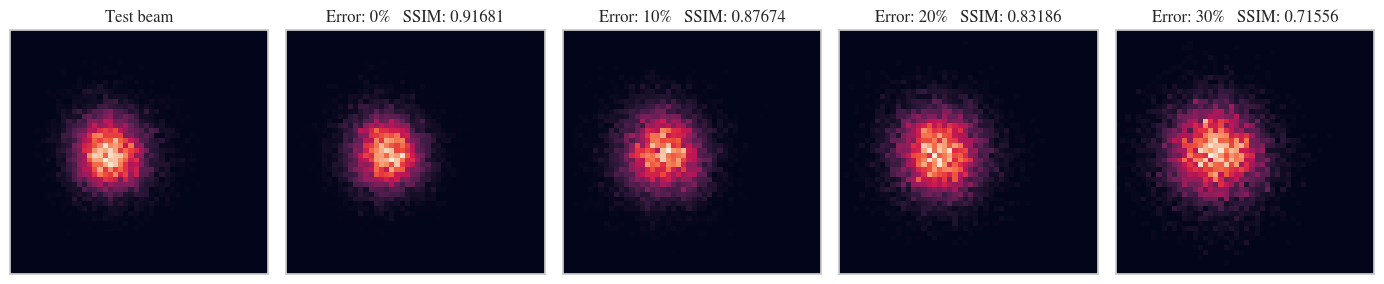

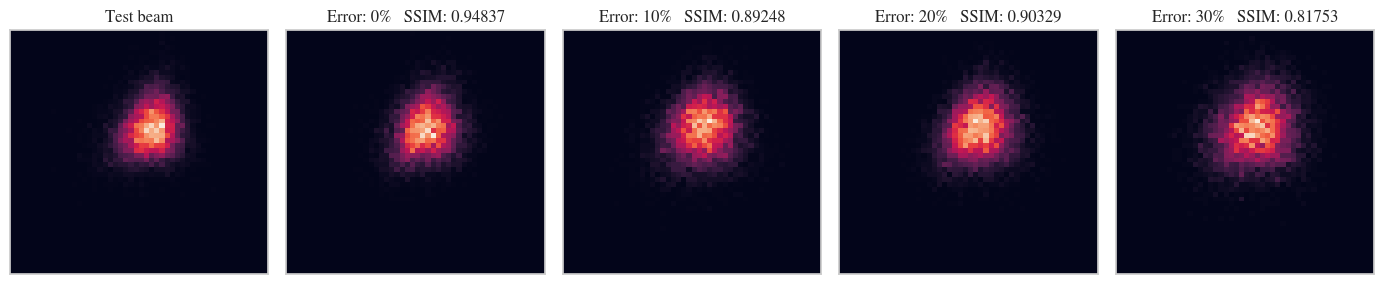

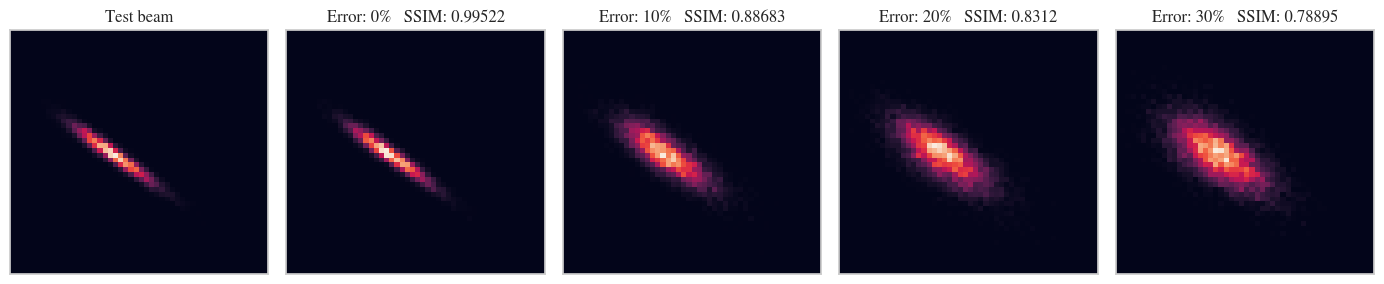

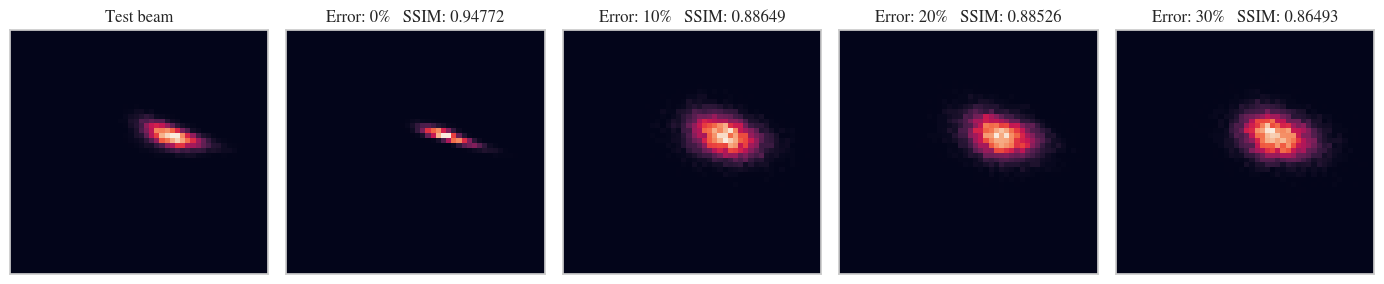

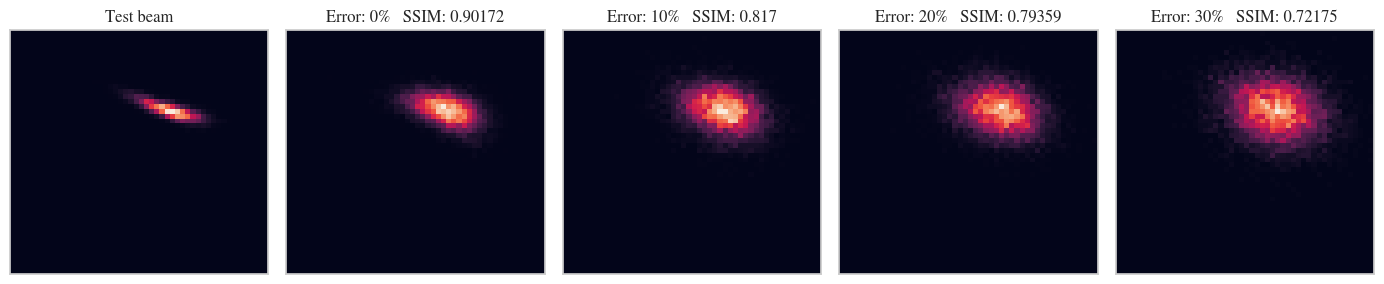

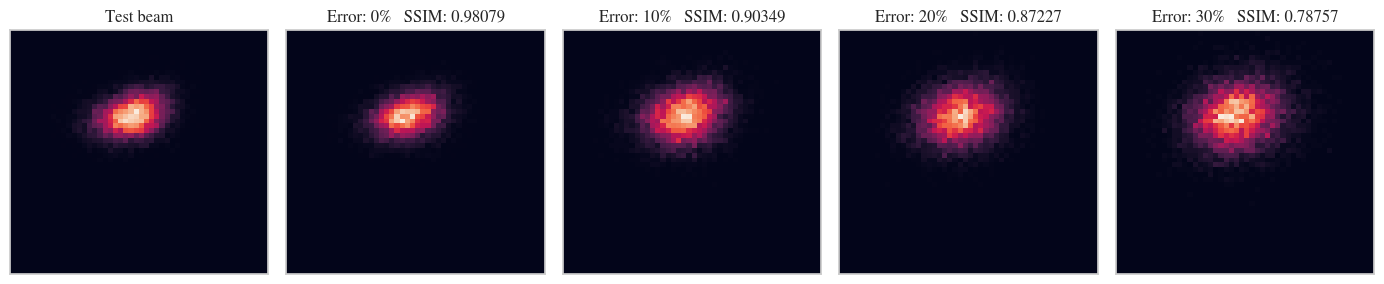

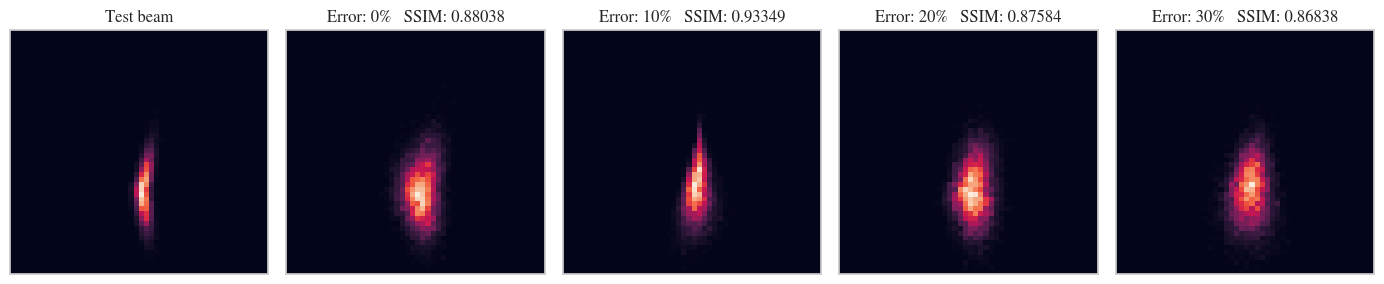

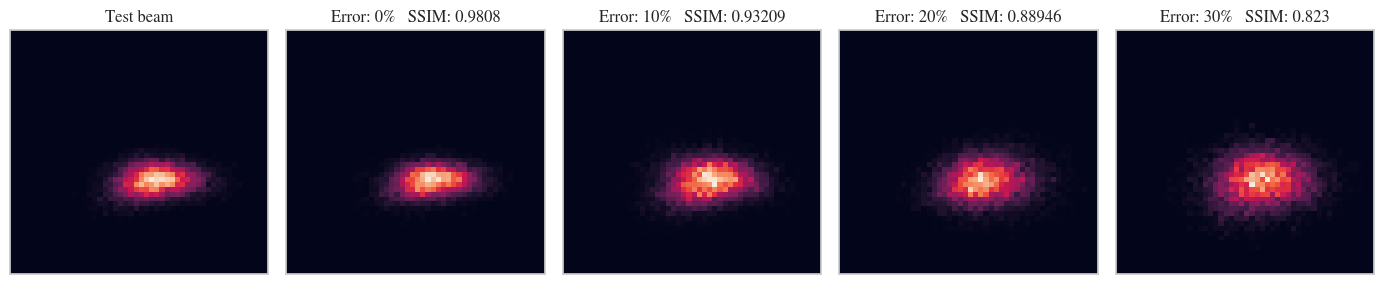

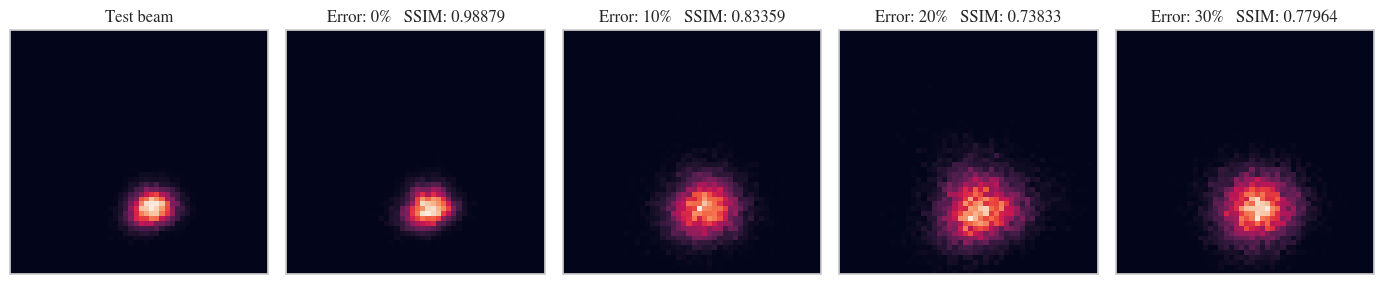

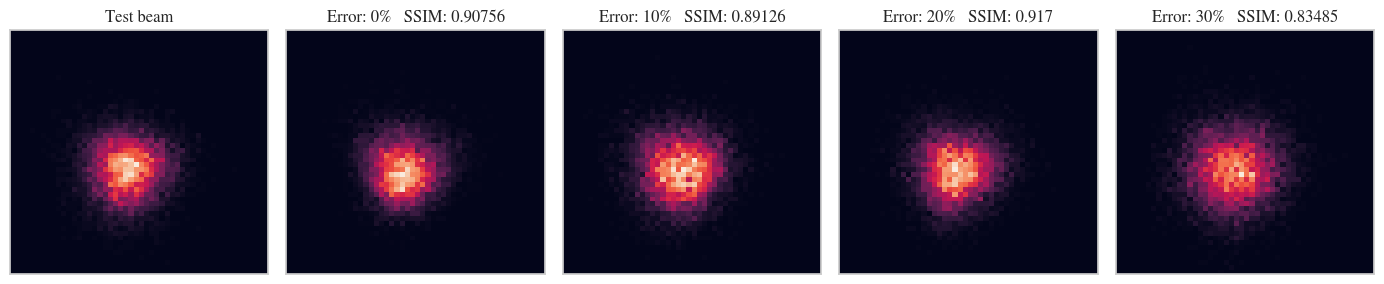

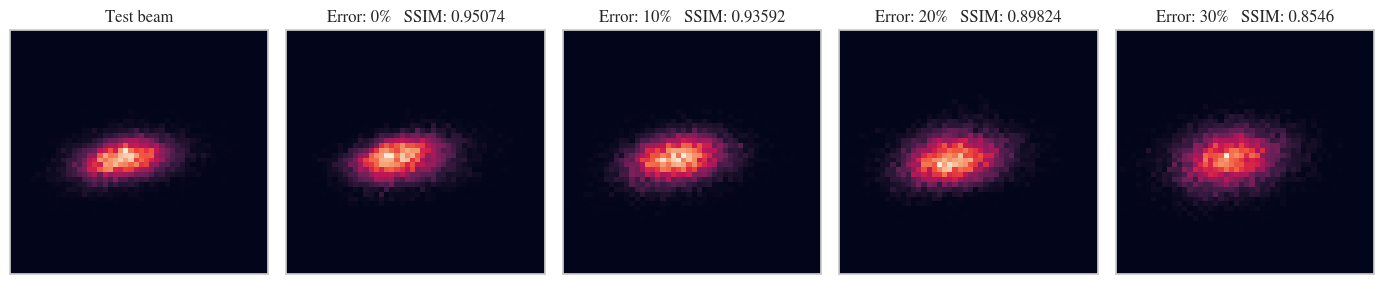

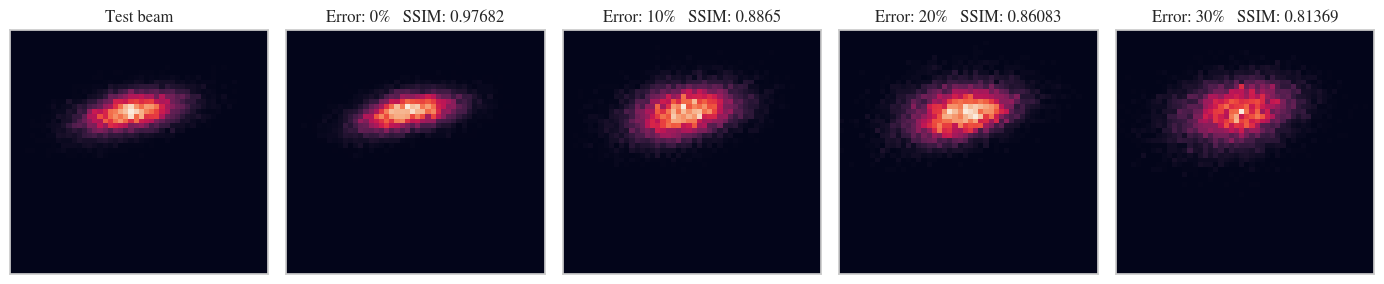

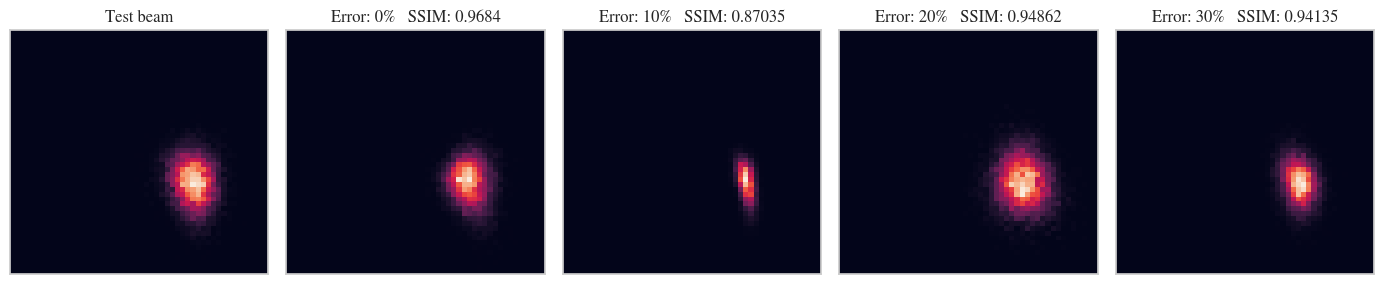

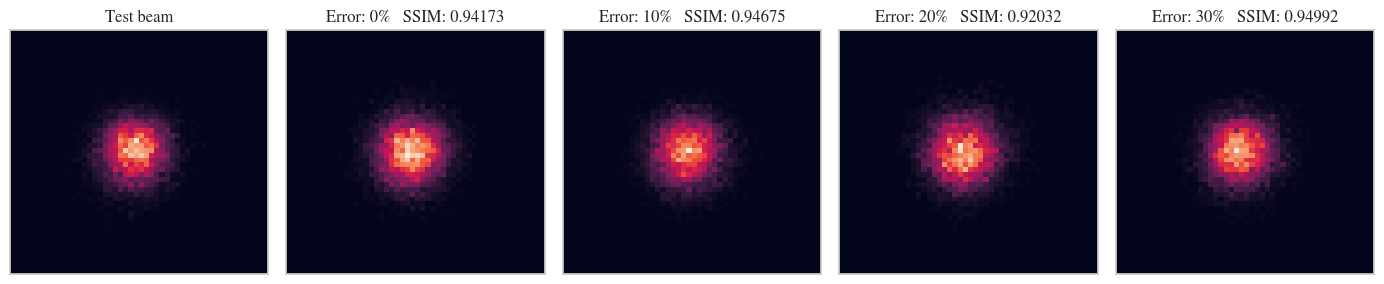

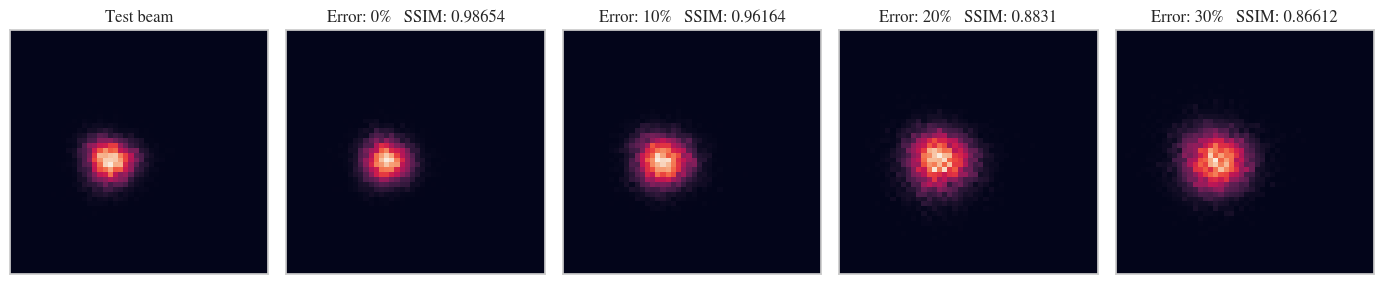

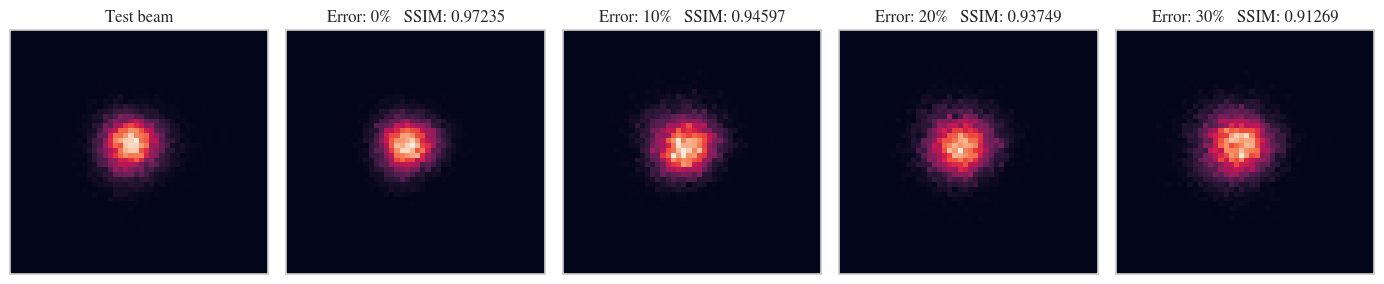

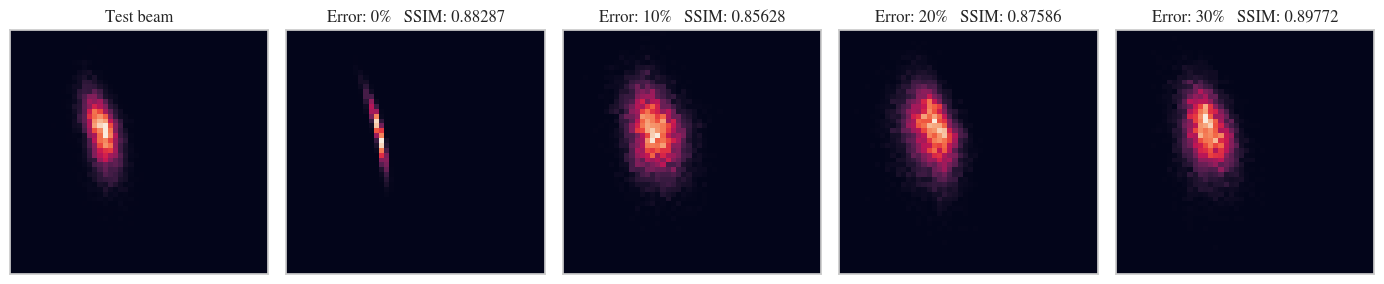

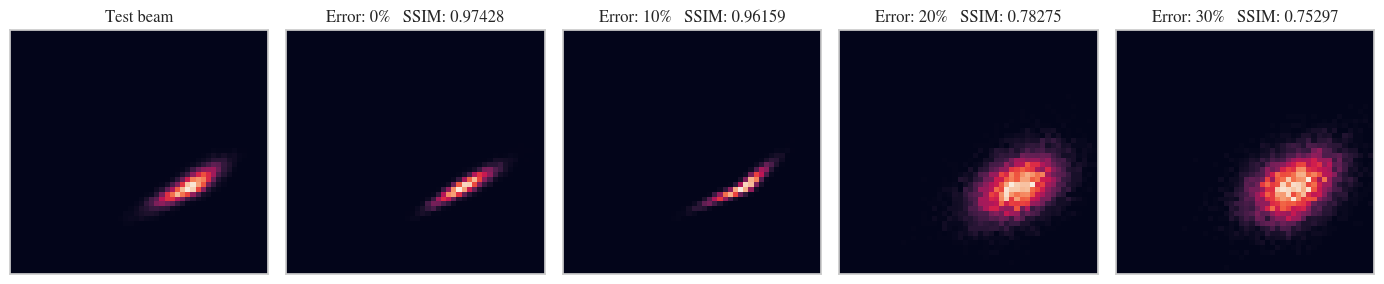

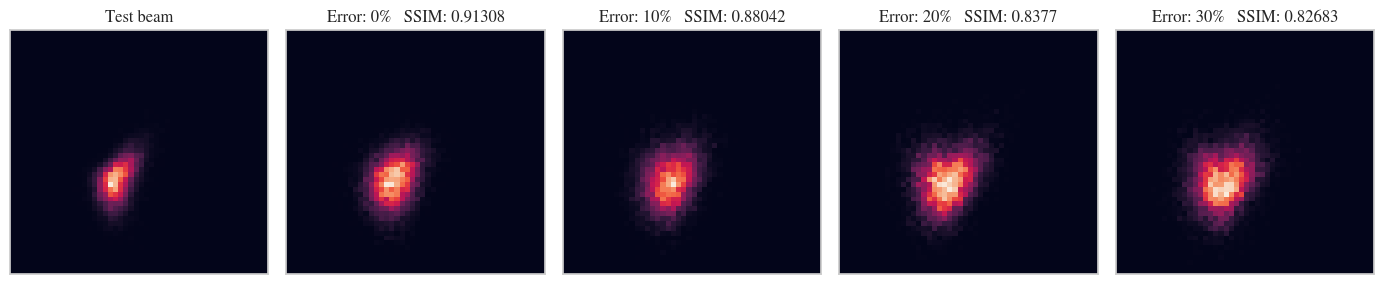

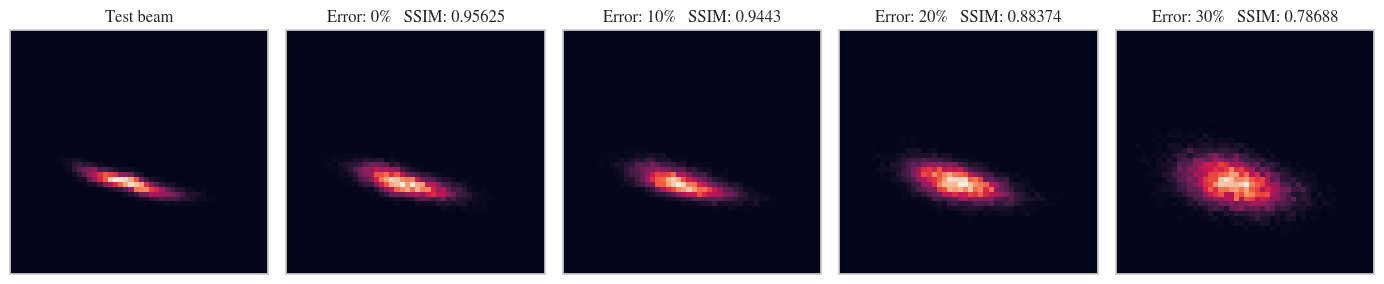

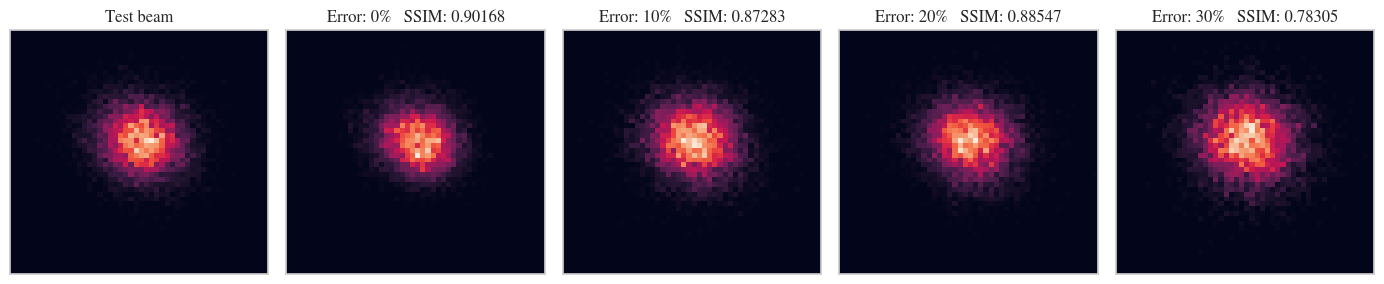

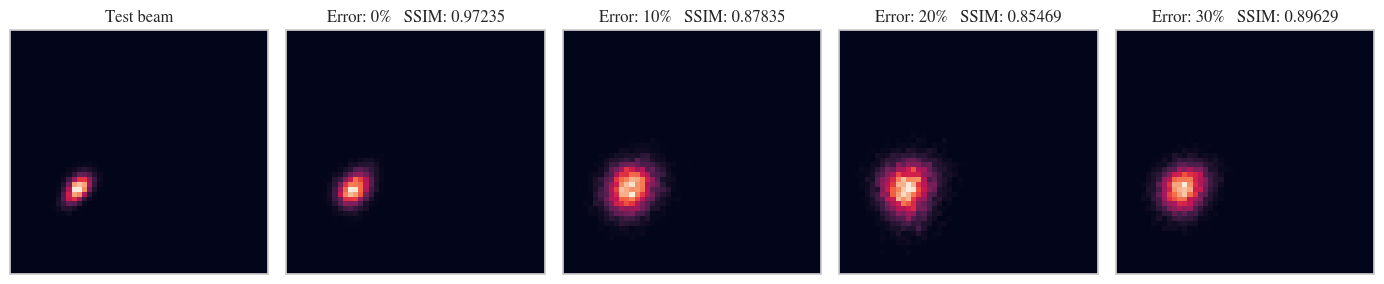

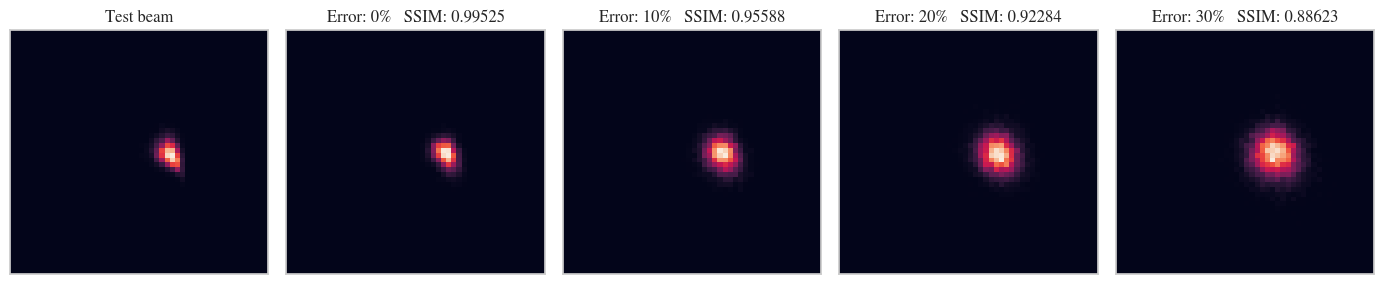

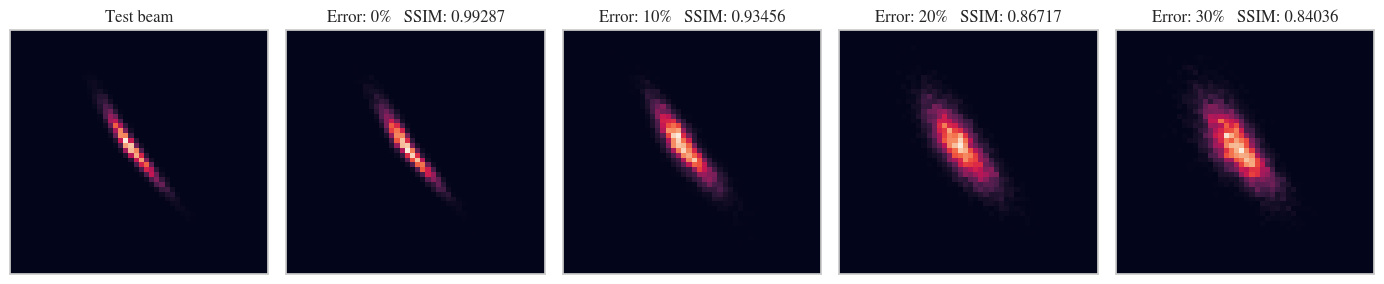

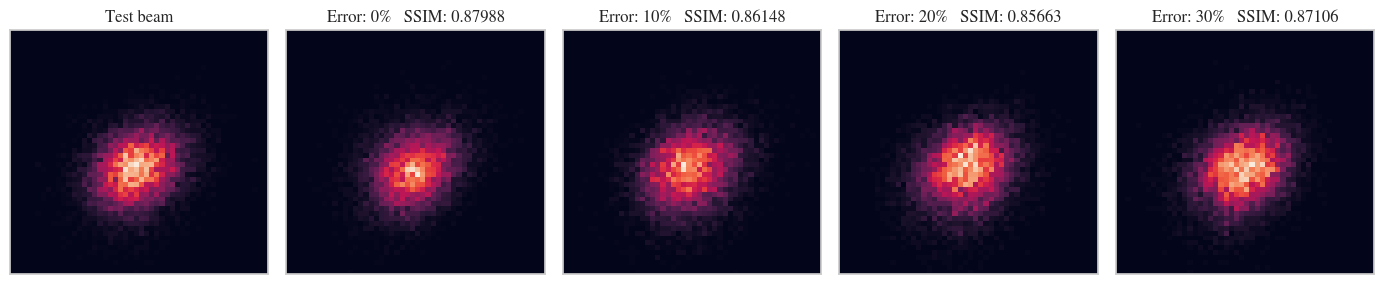

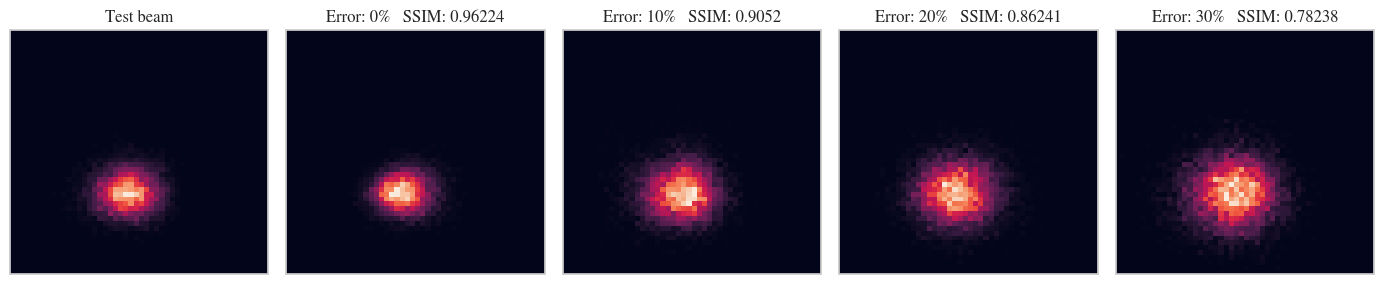

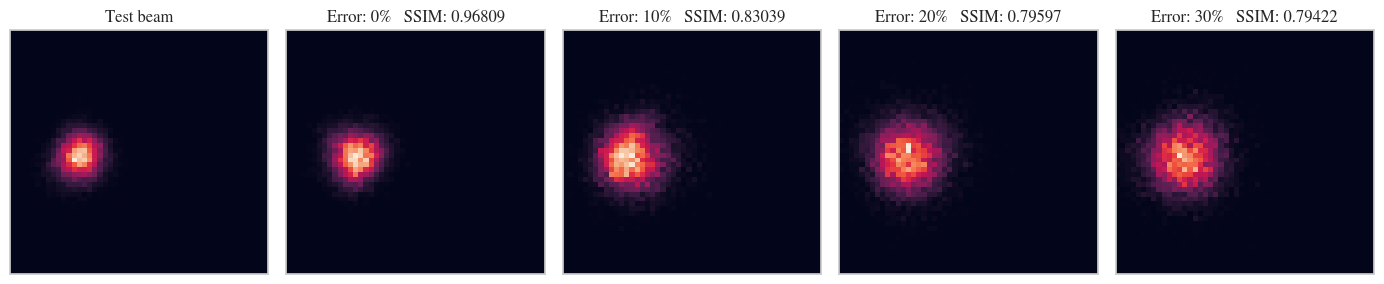

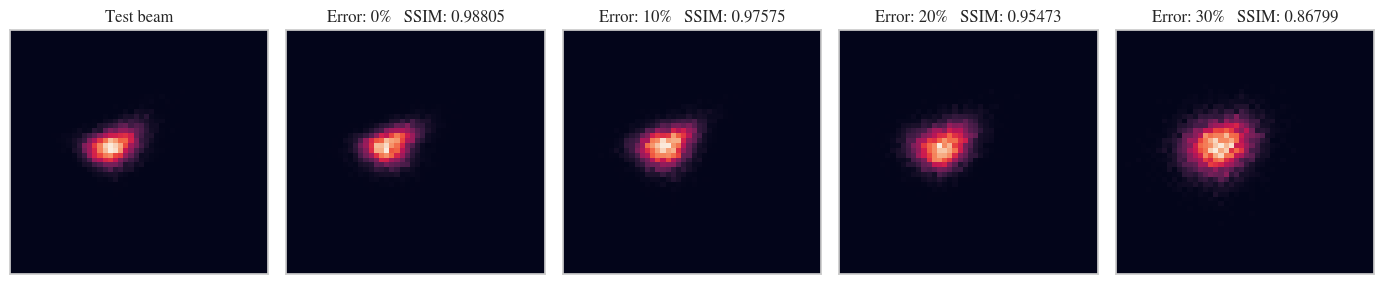

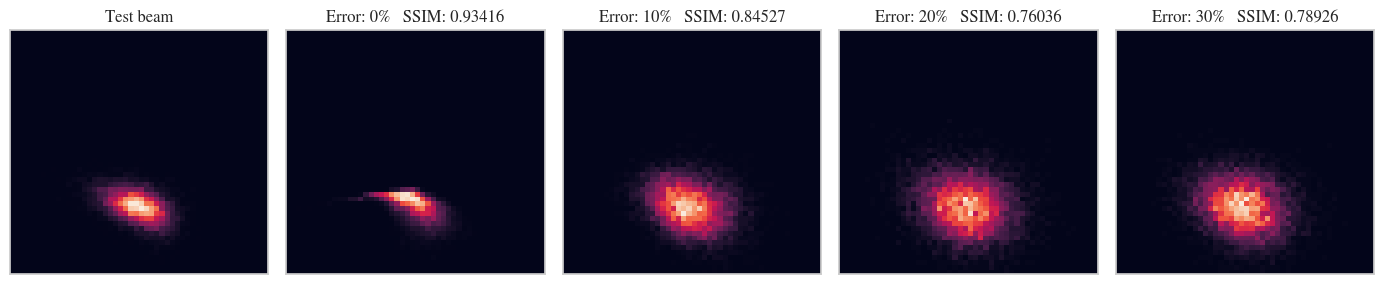

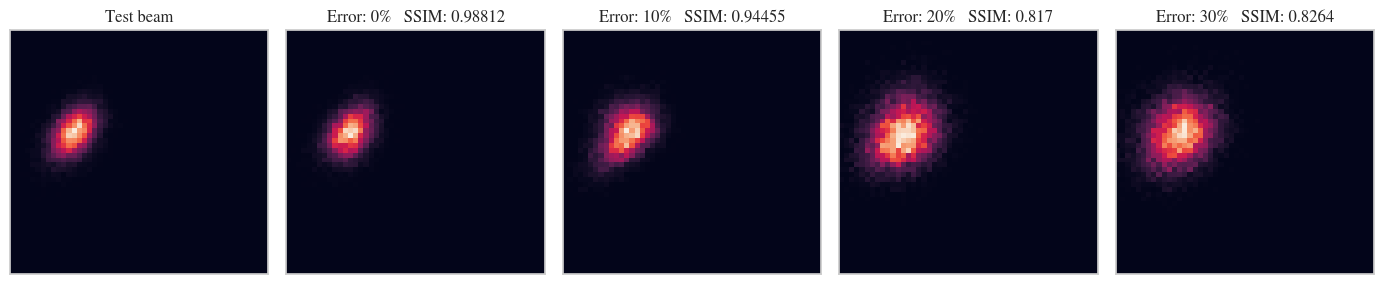

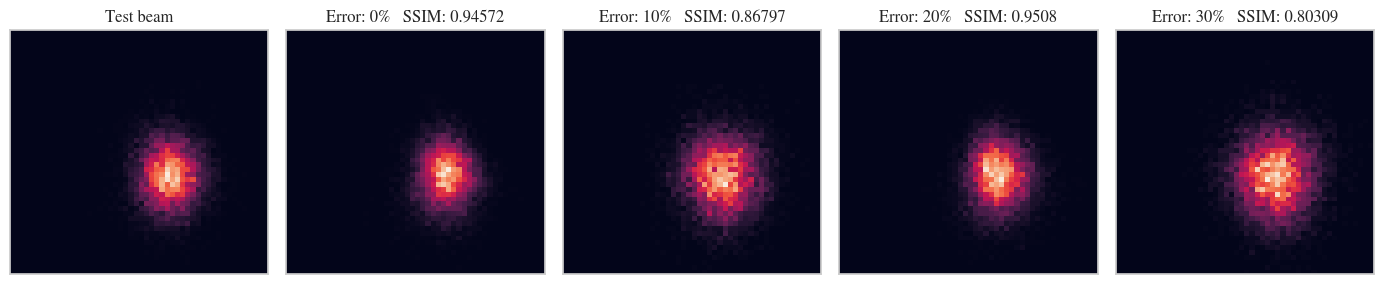

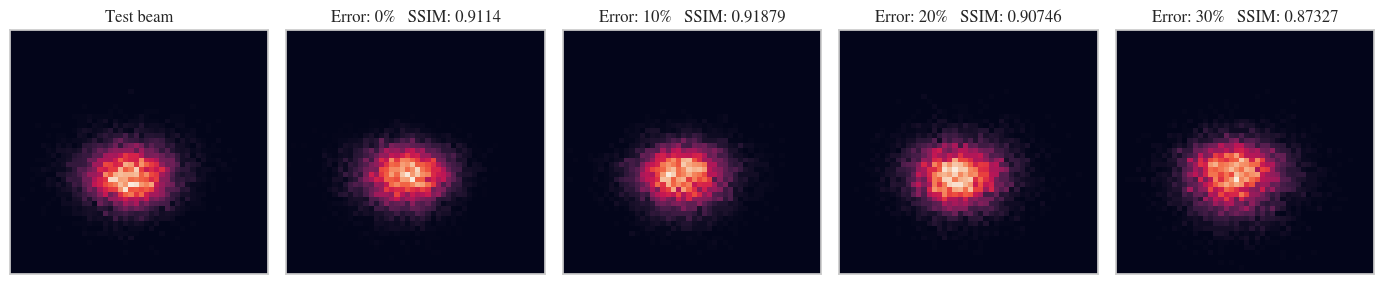

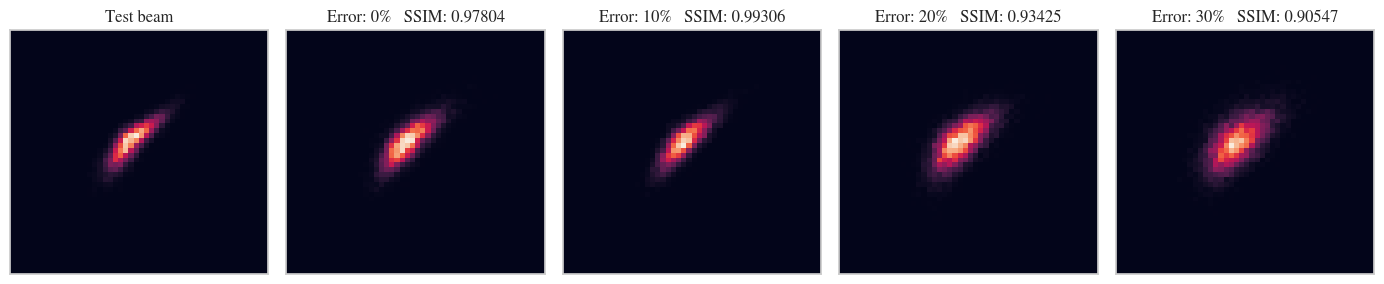

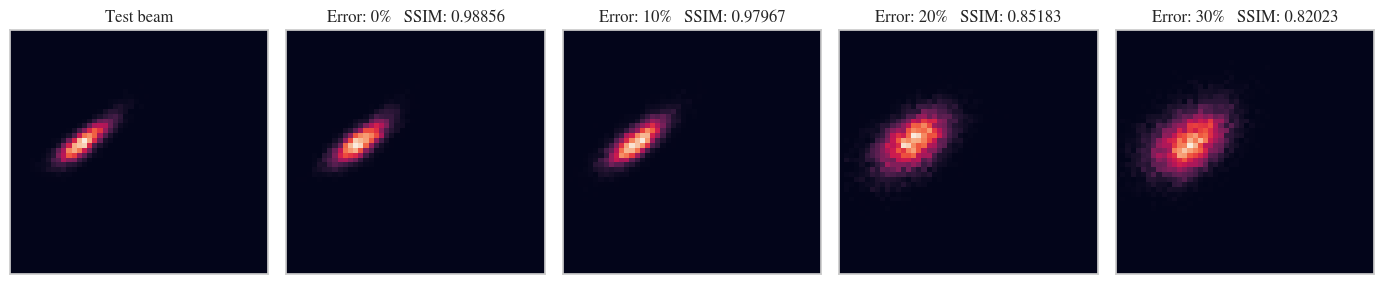

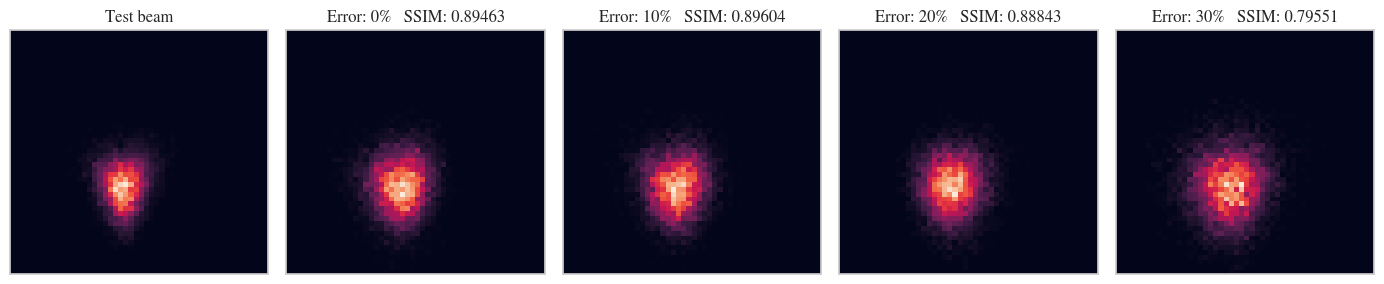

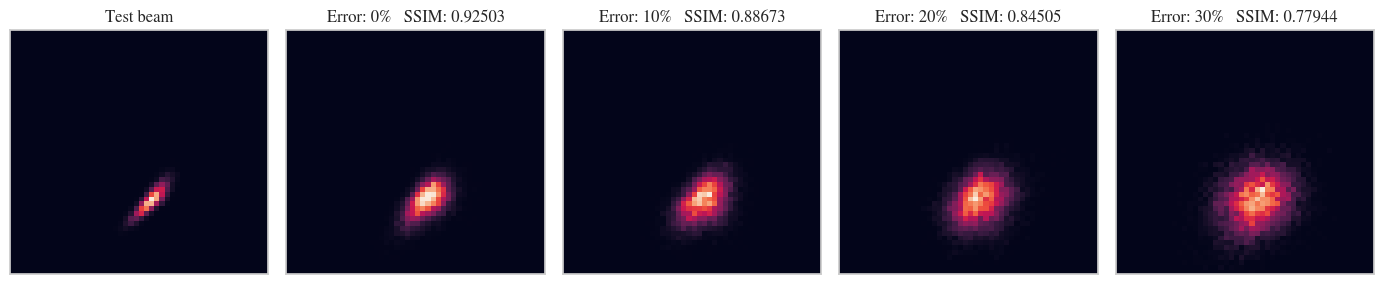

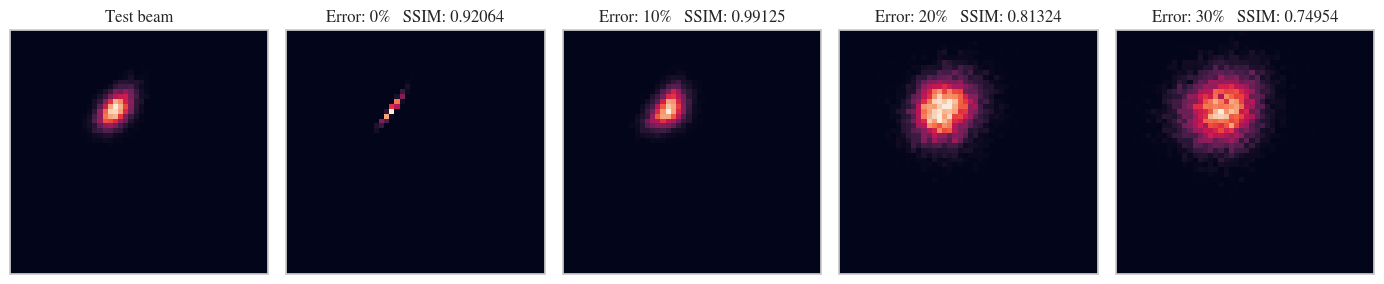

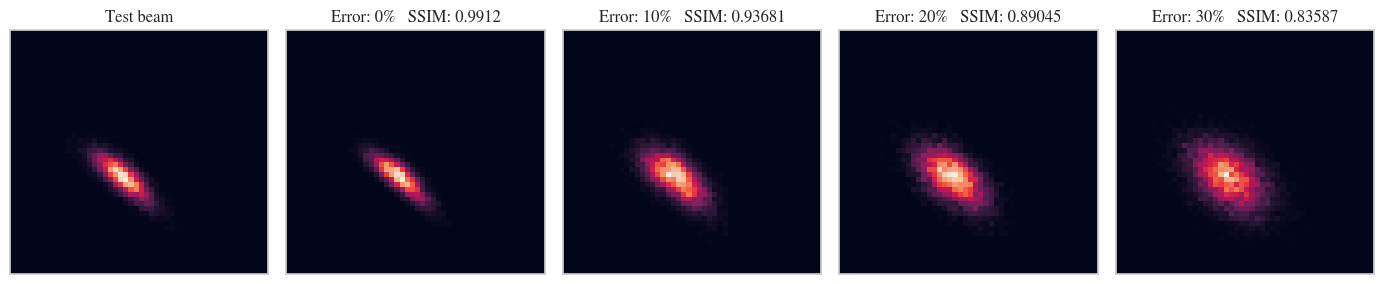

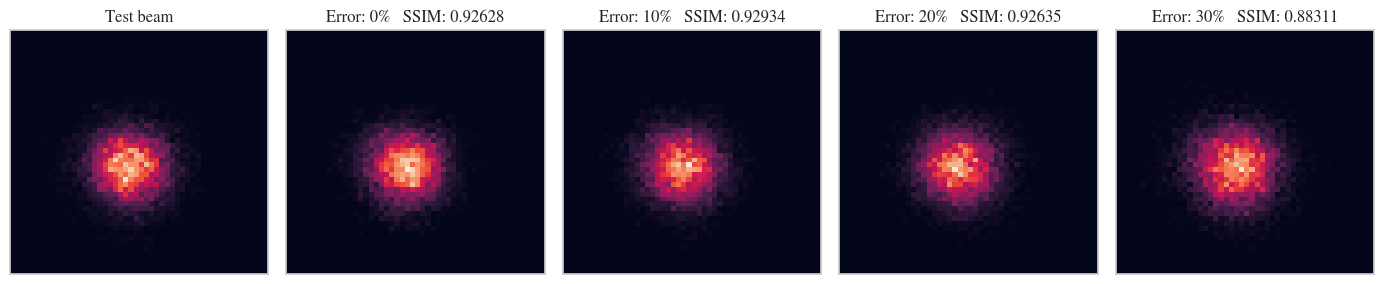

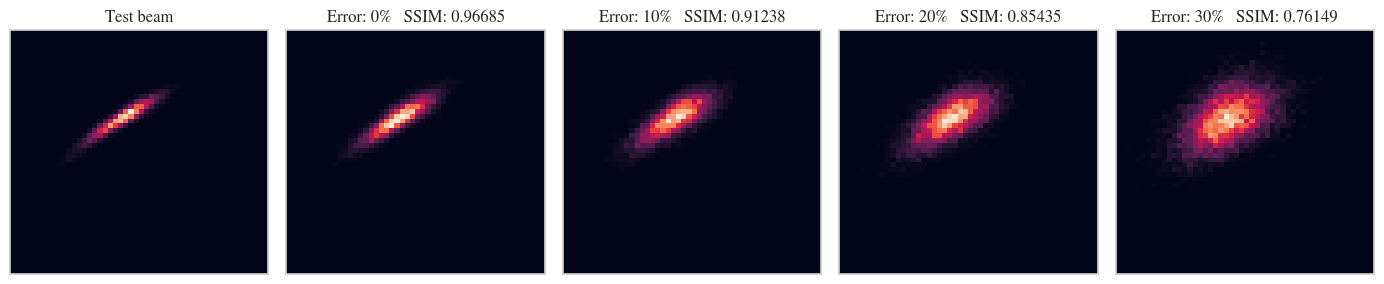

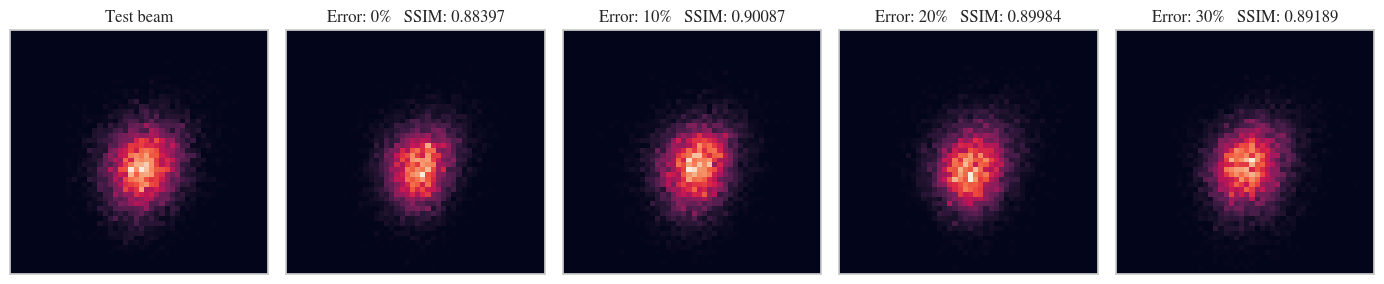

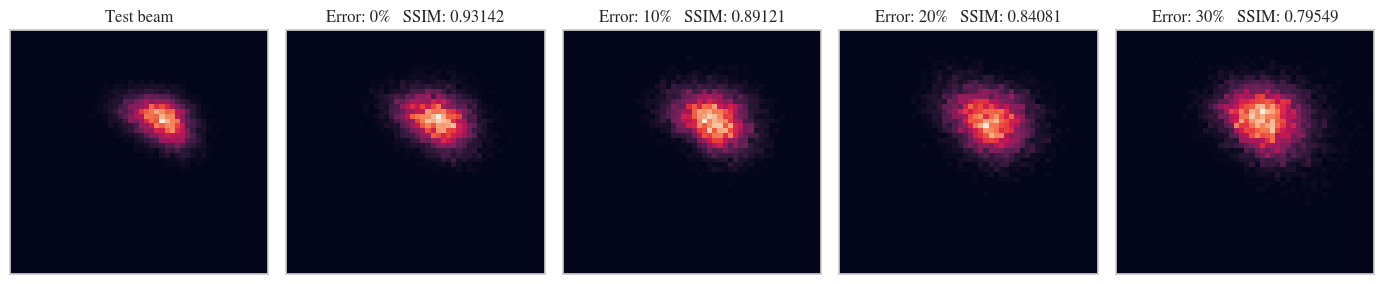

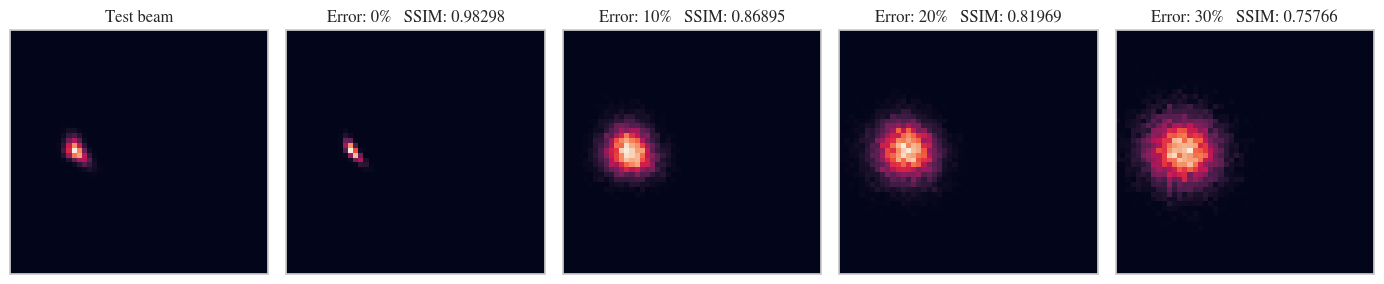

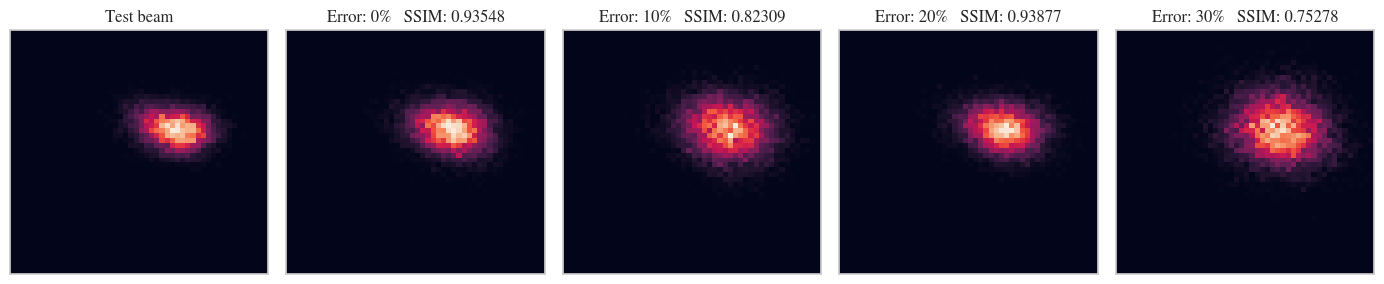

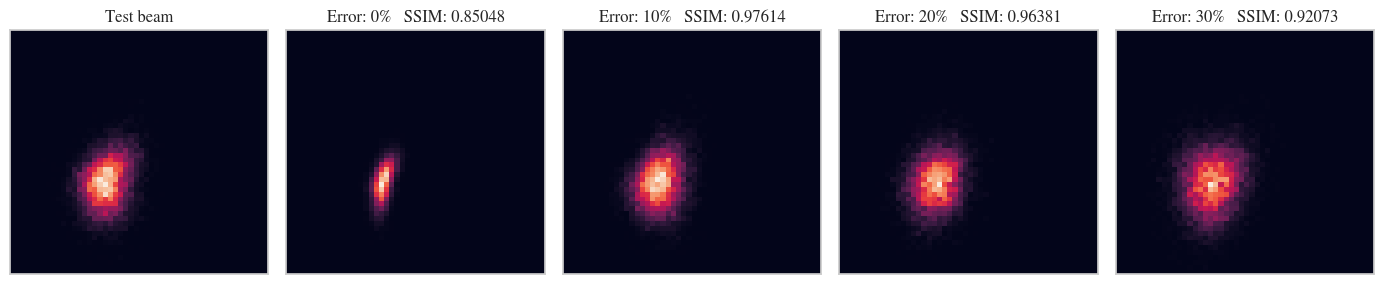

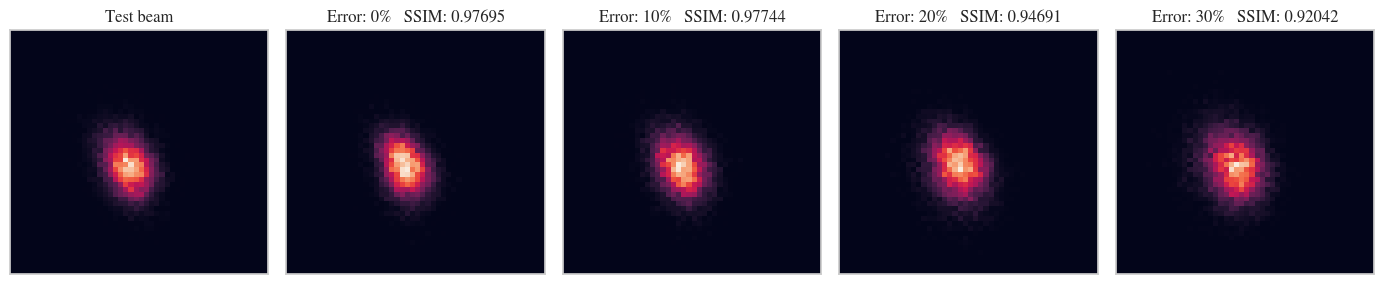

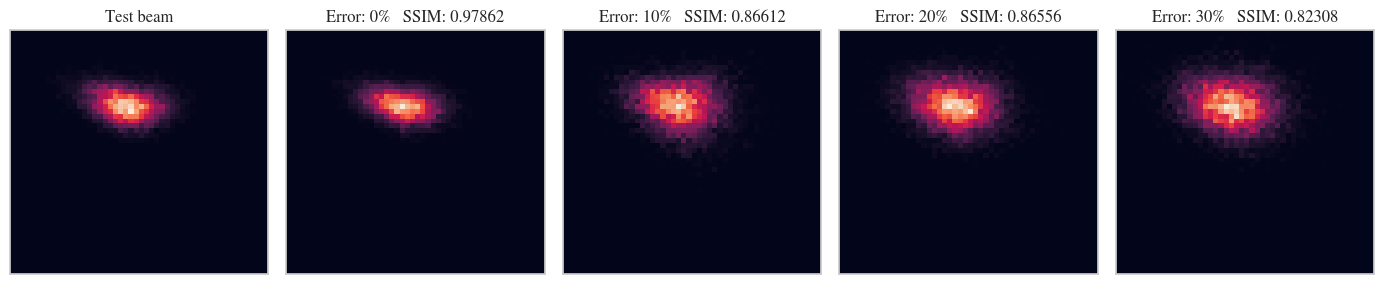

In [22]:
for i in 1:49
    noofplots = 5 
    
    fig, axes = plt.subplots(nrows=1, ncols=noofplots, sharey=true,figsize=(noofplots*2.8, 3))

    edges = range(-beam_pipe_radius, stop=beam_pipe_radius, length=histogram_bins+1)

    sca(axes[1])
    axes[1].xaxis.set_ticklabels([])
    axes[1].yaxis.set_ticklabels([])
    
    Z, xedges, yedges = hist2D(test_samples[i][:,2], test_samples[i][:,1], bins=[edges, edges])
    plt.pcolormesh(edges, edges, Z)
    # plt.colorbar()
    # xlabel("x [m]")
    # ylabel("y [m]")
    title("Test beam")
    for j in 2:noofplots
        sca(axes[j])
        axes[j].xaxis.set_ticklabels([])
        axes[j].yaxis.set_ticklabels([])

        y = std_noised[j-1][i]
        error = get_ssim_error(test_samples[i], y)

        Z, xedges, yedges = hist2D(y[:,2], y[:,1], bins=[edges, edges])
        plt.pcolormesh(edges, edges, Z)
        # plt.colorbar()
        title("Error: $(std_noise_levels[j-1])%   SSIM: $(round(error, sigdigits=5))")
        # xlabel("x [m]")

    end
    tight_layout()
    # savefig("2020.09.01 paper_plots/$(i).png", dpi=500)
    
end

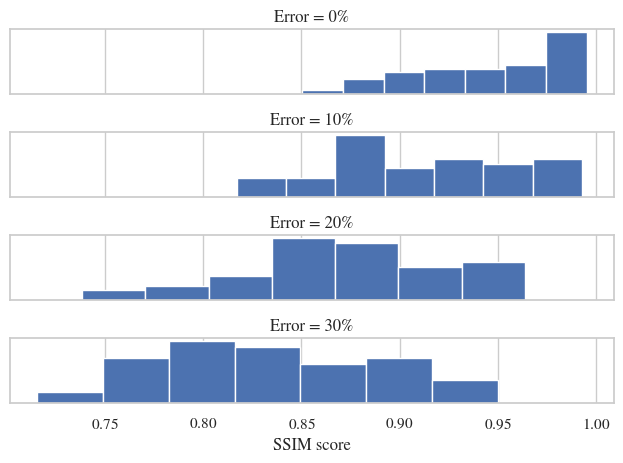

In [18]:
f, axes = plt.subplots(4, 1, sharex=true)
ylabs = ["0%", "10%", "20%", "30%"]
for i in 1:4
    axes[i].hist(std_noised_errors[i], bins=7)
    axes[i].set_yticks([])
    axes[i].set_title("Error = " * ylabs[i])
end

axes[4].set_xlabel("SSIM score")
tight_layout()

# savefig("2020.09.01 paper_plots/ssim_vs_noise_histograms.png", dpi=500)